# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install openai
!pip install tensorflow
!pip install scikit-learn
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [321]:
import os
import json
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, Image

import cv2
import openai
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from mediapipe.framework.formats import landmark_pb2
from sklearn.utils import check_random_state as sklear_set_seed

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
cv2.setRNGSeed(seed)
sklear_set_seed(seed)
tf. random.set_seed(seed)

# Prepare dataset

In [274]:
df_a = pd.read_csv("fehervali_lamp_night_webcam.csv", dtype={63: str}, header=None)
df_a = df_a[df_a[63].notna()]
print(len(df_a))
df_a.head(3)

79054


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.282440,0.600049,-1.870000e-07,0.315119,0.568314,-0.020261,0.341418,0.497320,-0.028145,0.345182,...,0.245077,0.454705,-0.029709,0.256525,0.503494,-0.027200,0.265023,0.532601,-0.019086,a
1,0.306540,0.464684,-2.530000e-07,0.345548,0.433487,-0.015010,0.376949,0.352773,-0.019309,0.383595,...,0.273192,0.294298,-0.030596,0.283822,0.349954,-0.026084,0.290784,0.386303,-0.016583,a
2,0.312548,0.466279,-2.500000e-07,0.351508,0.435728,-0.017326,0.383225,0.355989,-0.022386,0.390655,...,0.279703,0.295002,-0.031225,0.289348,0.351177,-0.027367,0.296098,0.386388,-0.017859,a


As the data cosists of sequential frames many of them are similar, so only every n frames are kept.

In [275]:
df_b = pd.read_csv("zsolca_afternoon_natural_light_lenovo.csv", dtype={63: str}, header=None)
df_b = df_b[df_b[63].notna()]
print(len(df_b))
df_b.head(3)

3897


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.413818,0.966917,3.870032e-07,0.368754,0.892463,0.025743,0.354324,0.812667,0.028953,0.364004,...,0.407242,0.642578,-0.051849,0.419412,0.585447,-0.045001,0.431459,0.543920,-0.038746,*
1,0.429636,0.971219,3.847637e-07,0.376920,0.896679,0.031091,0.355124,0.823586,0.035847,0.354776,...,0.408406,0.648279,-0.055534,0.416482,0.589365,-0.048640,0.427187,0.543676,-0.042008,*
2,0.429434,0.975407,3.824301e-07,0.375958,0.901011,0.032917,0.354162,0.829286,0.038783,0.352502,...,0.409734,0.649047,-0.054234,0.417152,0.588670,-0.046867,0.426816,0.542171,-0.039866,*


In [287]:
dataset_df = pd.concat([df_a, df_b])

In [288]:
n = 15
filtered_df = dataset_df[dataset_df.index % n == 0]

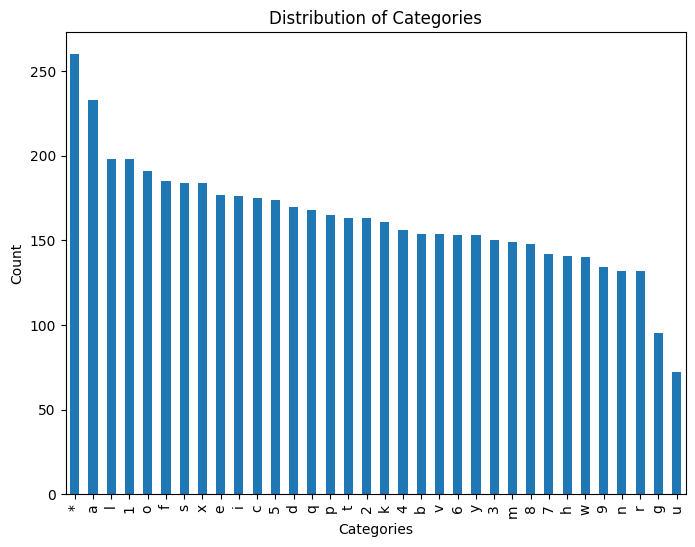

In [289]:
category_counts = filtered_df[63].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories')
plt.show()

In [290]:
PATH_TRAIN_DS = "shuffled_dataset_train.csv"
PATH_VALID_DS = "shuffled_dataset_train.csv"
shuffled_df = filtered_df.sample(frac=1).reset_index(drop=True)

train_df, valid_df = train_test_split(shuffled_df, train_size=0.8, shuffle=True)

train_df.to_csv(PATH_TRAIN_DS, index=False)
valid_df.to_csv(PATH_VALID_DS, index=False)

# Load dataset

In [322]:
sorted_cats = sorted(set(dataset_df[63].apply(lambda c: str(c))))
cat_to_num = {sign : i for i, sign in enumerate(sorted_cats)}
num_to_cat = {i : sign for sign, i in cat_to_num.items()}

with open("num_to_cat.json", "w") as json_file:
    json.dump(num_to_cat, json_file)

tf_cat_to_num = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(cat_to_num.keys()),
        values=list(cat_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="signs"
)

## Augmentation

Data looks like this: x1,y1,z1, x2,y2,z2 ....

In [292]:
def augment_lm(flat_xyz,
               flip_prob=0.3,
               zoom_prob=0.3,
               scale_prob=0.3,
               shear_prob=0.3,
               shift_prob=0.3,
               rotation_prob=0.3,
               scale=(0.9, 1.1),
               shear=(-0.15, 0.15),
               shift=(0.02, 0.035),
               degree=(-10, 10),
               zoom=(0.9, 1.1)):
    
    # Reshape flat data to [num_samples, 3]
    xyz = tf.reshape(flat_xyz, [21, 3]) # 21 coords for the hands
    
    # 1. Flip x coordinates with given probability
    if tf.random.uniform(()) < flip_prob:
        xyz = tf.stack([1-xyz[:, 0], xyz[:, 1], xyz[:, 2]], axis=1)
    
    # 2. Apply zoom with given probability
    if tf.random.uniform(()) < zoom_prob:
        zx = zy = tf.random.uniform((), *zoom)
    else:
        zx, zy = 1.0, 1.0
    
    # 3. scale
    if tf.random.uniform(()) < scale_prob:
        # Random scale factors for x and y
        sx = tf.random.uniform((), *scale)
        sy = tf.random.uniform((), *scale)
        sx *= zx
        sy *= zy
    else:
        sx = zx
        sy = zy

    # Random shear factors for x and y
    if tf.random.uniform(()) < shear_prob:
        shx = tf.random.uniform((), *shear)
        shy = tf.random.uniform((), *shear)
    else:
        shx = 0.
        shy = 0.

    # Random shift for x and y
    if tf.random.uniform(()) < shift_prob:
        tx = tf.random.uniform((), *shift)
        ty = tf.random.uniform((), *shift)
    else:
        tx = 0.
        ty = 0.

     # Random rotation in radians
    if tf.random.uniform(()) < rotation_prob:
        pi_on_180 = 0.017453292519943295
        theta = tf.random.uniform((), degree[0]*pi_on_180, degree[1]*pi_on_180)
    else:
        theta = 0.
        
    c, s = tf.cos(theta), tf.sin(theta)
    
    # Constructing the affine transformation matrix
    matrix = tf.convert_to_tensor([
        [sx*c + shx*s, -sy*s + shx*c, tx],
        [sx*s + shy*c, sy*c + shy*s, ty]
    ])
    # Apply transformation to x and y
    xy = tf.matmul(xyz[:, :2], tf.transpose(matrix[:, :2])) + matrix[:, 2]

    # Sometimes the transform is a little too intrusive and some parts of the hand lands off the canvas
    # Replace out-of-bound values with NaN
    condition = tf.logical_or(xy < 0.0, xy> 1.0)
    xy = tf.where(condition, tf.fill(tf.shape(xy), float('nan')), xy)

    # Combining transformed x and y with original z
    transformed_xyz = tf.concat([xy, tf.expand_dims(xyz[:, 2], axis=-1)], axis=1)
    
    # Flatten back to original shape
    flat_transformed = tf.reshape(transformed_xyz, [-1])
    
    return flat_transformed

In [293]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def display_lm(flat_xyz, *, display_shape=(300, 500)):
    xyz = np.reshape(flat_xyz, (21, 3))

    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(xyz[:, 0], xyz[:, 1], xyz[:, 2]):
        landmarks.landmark.add(x=x, y=y, z=z)
    
    frame = np.zeros((display_shape[0], display_shape[1], 3))
    
    mp_drawing.draw_landmarks(
                    frame,
                    landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
    
    plt.imshow(frame.astype(np.uint8))
    plt.show()

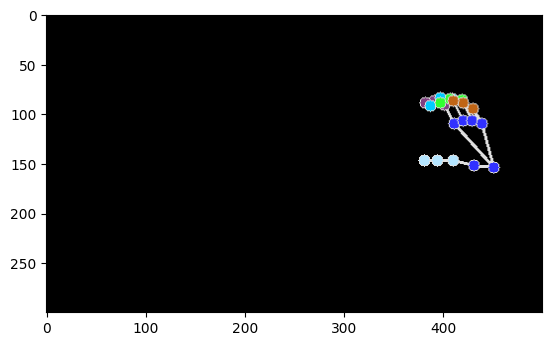

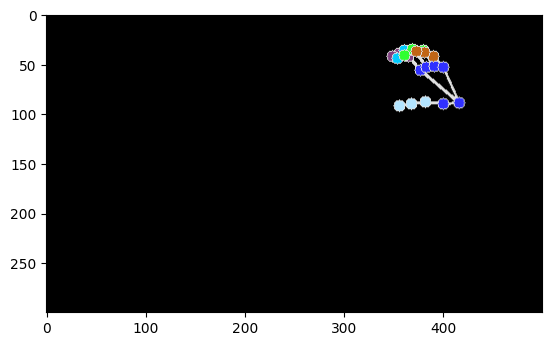

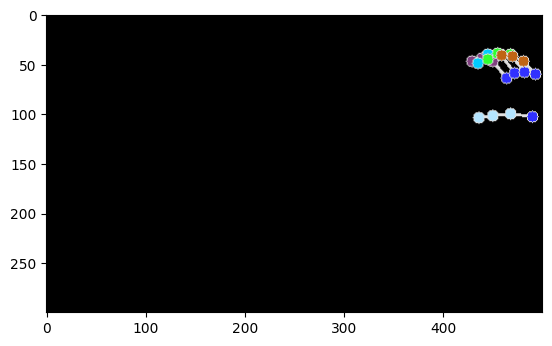

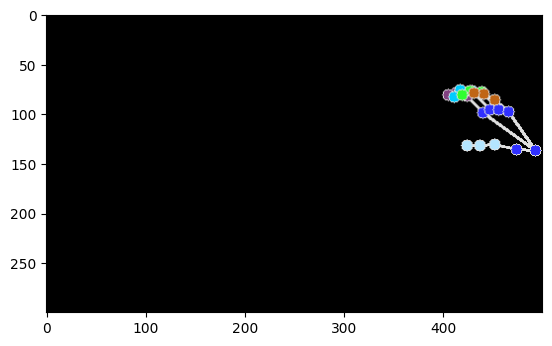

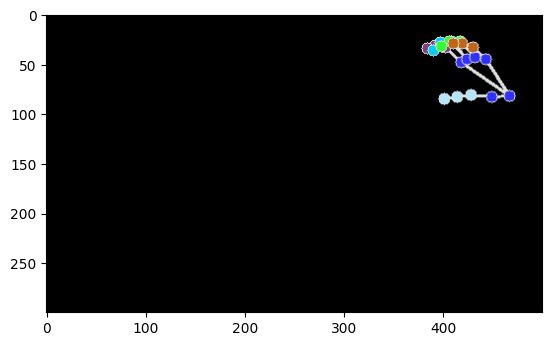

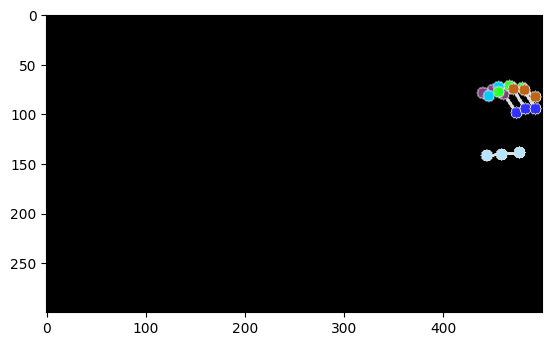

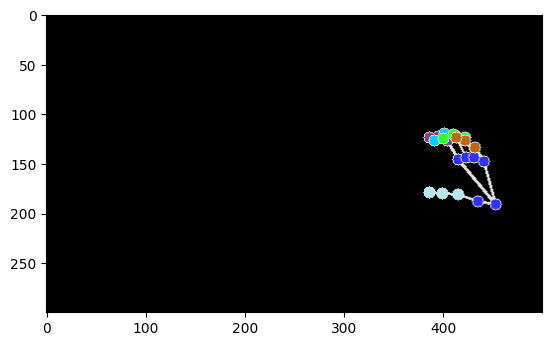

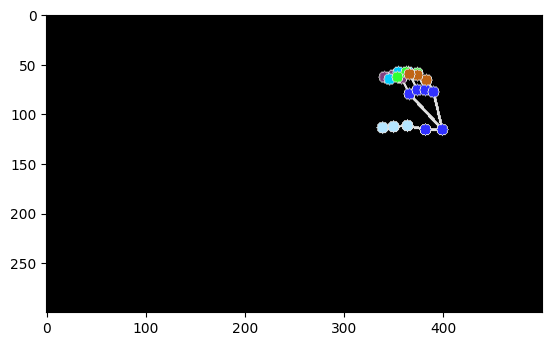

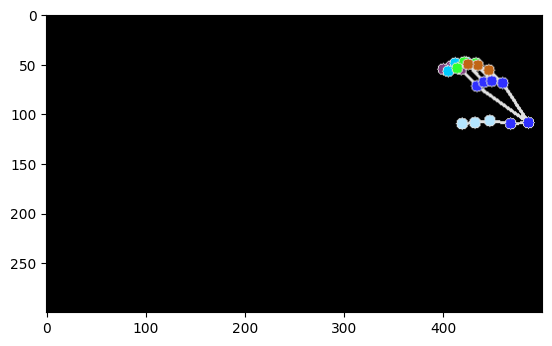

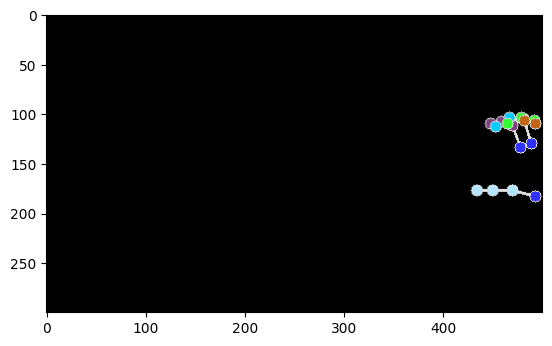

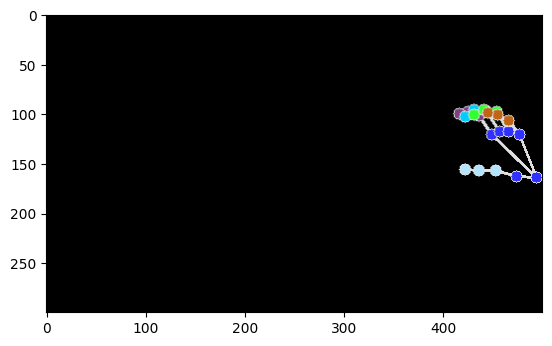

In [294]:
features = train_df.values[4000, :-1].astype(np.float32)
display_lm(features)
for _ in range(10):
    display_lm(augment_lm(features, 0., *([1.]*5)))

## Preprocessing

In [295]:
def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

def preprocess_lms(lm):
    mean = tf_nan_mean(lm)
    std = tf_nan_std(lm)
    lm = (lm - mean)/std
    lm = tf.where(tf.math.is_nan(lm),tf.constant(0.,lm.dtype),lm)
    return lm

def preprocess_cat(cat):
    return tf_cat_to_num.lookup(cat)

def preprocess_csv(line, augment=False):
    columns = tf.strings.split(line, ',')
    features = tf.strings.to_number(columns[:-1], out_type=tf.float32)
    
    if augment:
        features = augment_lm(features)
        
    return preprocess_lms(features), preprocess_cat(columns[-1])

In [296]:
def get_dataset(csv_path, *, batch_size=1, drop_remainder=False, shuffle_size=None, repeat=False, cache=False, augment=False):
    ds = tf.data.TextLineDataset(csv_path).skip(1) # skip header
    ds = ds.map(lambda x: preprocess_csv(x, augment=augment), tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle_size:
        ds = ds.shuffle(shuffle_size)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
        
    if batch_size > 1:
        ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    if cache:
        ds = ds.cache()
    
    return ds

batch_size = 256

train_ds = get_dataset(PATH_TRAIN_DS, batch_size=batch_size, shuffle_size=4*batch_size, augment=True)
valid_ds = get_dataset(PATH_VALID_DS, batch_size=batch_size)

In [297]:
for batch in train_ds:
    print(batch)
    break

(<tf.Tensor: shape=(256, 63), dtype=float32, numpy=
array([[ 0.5090022 ,  0.8801957 , -1.2463251 , ...,  0.68577904,
         0.9965002 , -1.3950729 ],
       [ 0.        ,  1.147724  , -0.6853489 , ...,  0.        ,
         0.43915135, -0.782336  ],
       [ 1.1330892 ,  0.37378392, -1.0479949 , ...,  0.87106806,
         0.41970313, -1.2937504 ],
       ...,
       [ 0.972916  ,  1.5507959 , -1.4986883 , ...,  0.29639202,
         0.706422  , -1.4971558 ],
       [ 0.15013254,  2.1127462 , -1.1924918 , ...,  0.12875123,
         0.40124053, -1.3308434 ],
       [ 0.98728836,  0.17587748, -1.2043797 , ...,  1.2494785 ,
         0.19694442, -1.2265393 ]], dtype=float32)>, <tf.Tensor: shape=(256,), dtype=int32, numpy=
array([24, 14, 25, 33,  1, 31, 18, 26, 24,  1, 21,  0, 31, 11,  4, 15, 22,
        9,  0, 21, 32,  7, 25, 28, 15, 30, 14, 31, 25,  1, 21, 26,  5, 28,
       24, 28,  1,  0,  1, 22,  6, 32, 24,  3, 21, 20,  0, 12, 13,  0, 10,
       30, 15,  4, 20, 23, 24,  4, 28, 33, 27, 

# Models

## Dense model

In [298]:
model = keras.Sequential([
    layers.Input(shape=(63,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(sorted_cats), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               8192      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 34)                2210      
                                                                 
Total params: 18658 (72.88 KB)
Trainable params: 18658 (72.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## CNN model

In [302]:
model = keras.Sequential([
    layers.Input(shape=(63,)),
    layers.Lambda(lambda x: keras.backend.expand_dims(x, axis=-1)),
    layers.Conv1D(4, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(sorted_cats), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 63, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 61, 4)             16        
                                                                 
 flatten_3 (Flatten)         (None, 244)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               31360     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)               

In [303]:
%%time
model.fit(train_ds,
          validation_data=valid_ds,
          epochs=300,
          verbose = 2)

Epoch 1/300
5/5 - 1s - loss: 3.5794 - accuracy: 0.0199 - val_loss: 3.5049 - val_accuracy: 0.0488 - 1s/epoch - 275ms/step
Epoch 2/300
5/5 - 0s - loss: 3.5045 - accuracy: 0.0461 - val_loss: 3.4742 - val_accuracy: 0.0832 - 311ms/epoch - 62ms/step
Epoch 3/300
5/5 - 0s - loss: 3.4755 - accuracy: 0.0588 - val_loss: 3.4471 - val_accuracy: 0.0859 - 333ms/epoch - 67ms/step
Epoch 4/300
5/5 - 0s - loss: 3.4582 - accuracy: 0.0561 - val_loss: 3.4134 - val_accuracy: 0.1049 - 328ms/epoch - 66ms/step
Epoch 5/300
5/5 - 0s - loss: 3.4295 - accuracy: 0.0922 - val_loss: 3.3773 - val_accuracy: 0.1094 - 382ms/epoch - 76ms/step
Epoch 6/300
5/5 - 0s - loss: 3.3927 - accuracy: 0.0741 - val_loss: 3.3343 - val_accuracy: 0.1374 - 314ms/epoch - 63ms/step
Epoch 7/300
5/5 - 0s - loss: 3.3575 - accuracy: 0.0886 - val_loss: 3.2860 - val_accuracy: 0.1365 - 294ms/epoch - 59ms/step
Epoch 8/300
5/5 - 0s - loss: 3.3111 - accuracy: 0.1049 - val_loss: 3.2303 - val_accuracy: 0.1492 - 320ms/epoch - 64ms/step
Epoch 9/300
5/5 - 

In [323]:
tf.saved_model.save(model, "static_fingerspelling_cnn_model")

INFO:tensorflow:Assets written to: static_fingerspelling_cnn_model\assets


INFO:tensorflow:Assets written to: static_fingerspelling_cnn_model\assets


# Testing

## Util to work with video feeds using mediapipe hands

In [300]:
WEBCAM = 0

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def video_loop_mp_hands(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_hands.Hands(model_complexity=1,max_num_hands=1,min_detection_confidence=0.5,min_tracking_confidence=0.5) as hands:
            while True:
                _, image = video.read()
    
                if image is None:
                    break

                image. flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = hands.process(image)

                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks: # 1 hand only
                        # Draw landmarks
                        mp_drawing.draw_landmarks(
                            image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())
        
                        # Get bounding box for the hand
                        lms = hand_landmarks.landmark
                        x_coords = [lm.x for lm in lms]
                        y_coords = [lm.y for lm in lms]
                        min_x, max_x = int(min(x_coords) * image.shape[1]), int(max(x_coords) * image.shape[1])
                        min_y, max_y = int(min(y_coords) * image.shape[0]), int(max(y_coords) * image.shape[0])

                        # Draw the bounding box around the hand
                        #cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)  # RGB green
                
                        data = []
                        for lm in lms:
                            data.extend([lm.x, lm.y, lm.z])

                        # Get prediction and probability from function
                        pred, prob = process_data_func(data)
                        
                        image = cv2.flip(image, 1)
                        # Display prediction and probability near the bounding box
                        label = f"{pred}: {prob:.2f}%" if pred else "unknown"
                        cv2.putText(image, label.upper(), (image.shape[1] - min_x, min_y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2, cv2.LINE_AA)
                else:
                    image = cv2.flip(image, 1)
                
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

## Predict every frame model for isolated signs

In [309]:
def process_frame(frame):
    x = preprocess_lms(frame)
    probs = model(np.array([x]))
    prob = np.max(probs, axis=1)[0]
    pred = np.argmax(probs)
    pred = num_to_cat[pred]
    return pred, prob

video_loop_mp_hands(WEBCAM, process_frame)

None

## Buffered model for isolated signs

In [255]:
class BufferedModel:
    def __init__(self, model, preprocess_fn, *, confidence, buffer_size):
        self.model = model
        self.preprocess_fn = preprocess_fn
        self.buffer = deque(maxlen=buffer_size)
        self.confidence_threshold = int(buffer_size * confidence)
        self.buffer_size = buffer_size

    def process_frame(self, frame):
        x = self.preprocess_fn(frame)
        probs = self.model(np.array([x]))
        prob = np.max(probs, axis=1)[0]
        pred = np.argmax(probs)

        # Store tuple (prediction, probability) in the buffer
        self.buffer.append((pred, prob))

        # Retrieve the most common prediction from the buffer
        buffered_pred, count = Counter([item[0] for item in self.buffer]).most_common(1)[0]

        # If confidence threshold is met, compute average probability for the most common prediction
        if count >= self.confidence_threshold:
            avg_prob = sum(item[1] for item in self.buffer if item[0] == buffered_pred) / count
            return num_to_cat[buffered_pred], avg_prob

        return None, 0.

None

In [305]:
buffered_model = BufferedModel(model, preprocess_lms, confidence=0.7, buffer_size=10)
video_loop_mp_hands(WEBCAM, lambda data: buffered_model.process_frame(data))

None

## Buffered model with top_k and top_p parameters

In [306]:
class ProbabilisticBufferedModel:
    def __init__(self, model, preprocess_fn, *, confidence, buffer_size, top_k, top_p):
        self.model = model
        self.preprocess_fn = preprocess_fn
        self.buffer = deque(maxlen=buffer_size)
        self.confidence_threshold = int(buffer_size * confidence)
        self.buffer_size = buffer_size
        self.top_k = top_k
        self.top_p = top_p

    def process_frame(self, frame):
        x = self.preprocess_fn(frame)
        probs = self.model(np.array([x]))[0].numpy()
        
        # Sort the classes based on probabilities
        sorted_indices = np.argsort(probs)[::-1]
        
        # Select up to top_k classes whose probabilities sum up to less than top_p
        cumulative_probs = np.cumsum(probs[sorted_indices])

        # If the model is confident in the first place choice choose that
        if self.top_p < cumulative_probs[0]:
            chosen_class = sorted_indices[0]
            chosen_prob = probs[chosen_class]
        else:
            selected_indices = sorted_indices[:self.top_k][cumulative_probs[:self.top_k] <= self.top_p]
            
            # Normalize the probabilities of the selected classes
            normalized_probs = probs[selected_indices] / sum(probs[selected_indices])
            
            # Randomly select one of the classes based on their normalized probabilities
            chosen_class = np.random.choice(selected_indices, p=normalized_probs)
            chosen_prob = probs[chosen_class]
        
        # Add the chosen class and its probability to the buffer
        self.buffer.append((chosen_class, chosen_prob))

        # Retrieve the most common prediction from the buffer
        buffered_pred, count = Counter([item[0] for item in self.buffer]).most_common(1)[0]

        # If confidence threshold is met, compute average probability for the most common prediction
        if count >= self.confidence_threshold:
            avg_prob = sum(item[1] for item in self.buffer if item[0] == buffered_pred) / count
            return num_to_cat[buffered_pred], avg_prob

        return None, 0.

In [307]:
prob_buffered_model = ProbabilisticBufferedModel(model, preprocess_lms, confidence=0.7, buffer_size=10, top_k=3, top_p=0.9)
video_loop_mp_hands(WEBCAM, lambda data: prob_buffered_model.process_frame(data))

None

# Continuous model

handle words

In [312]:
class ContinuousModel:
    def __init__(self):
        self.buffered_model = ProbabilisticBufferedModel(model, preprocess_lms, confidence=0.8, buffer_size=20, top_k=3, top_p=0.9)
        self.last_pred = None
        self.word = ""

    def process_frame(self, frame):
        pred, prob = self.buffered_model.process_frame(frame)
        if self.last_pred != pred and pred is not None and prob > 0.7 and pred != "*":
            self.last_pred = pred
            self.word += pred
        return self.word, 0.

c_model = ContinuousModel()
video_loop_mp_hands(WEBCAM, lambda data: c_model.process_frame(data))

None

## Continuous model with signing detection

For this model the mediapipe holistic model is needed, gather more pose information than simply the 2 hands.

### Handle mediapipe holistic model

In [256]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def draw_landmarks_on_image(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    return image

def video_loop_mp_holistics(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
            while True:
                _, frame = video.read()
    
                if frame is None:
                    break
    
                #image = cv2.resize(frame, (360, 240))
                image=frame
    
                # To improve performance, optionally mark the image as not writeable to pass by reference.
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = holistic.process(image)

                # Run the model
                process_data_func(results)
    
                # Draw landmark annotation on the image.
                image = draw_landmarks_on_image(image, results)
    
                image = cv2.flip(image, 1)
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

### Signing detection model

In [258]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

def extract_for_signing_detection(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

# Only load once
signing_detection_model = tf.saved_model.load("signing_detection_model")

class SigningDetectionModel:
    def __init__(self):
        self.signing_detection_model_input = list(np.zeros((15, 156)))

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        return signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy() == 1

class BufferedSigningDetectionModel:
    def __init__(self, buffer_len=5, confidence_number=3):
        self.signing_detection_model_input = list(np.zeros((15, 156)))
        self.signing_detector_buffer = deque(maxlen=buffer_len)
        self.confidence_number = confidence_number 

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        pred = signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy()
        self.signing_detector_buffer.append(pred)
        buffered_pred, count = Counter(self.signing_detector_buffer).most_common(1)[0]
        if count >= self.confidence_number:
            return buffered_pred == 1
        else:
            return False

OSError: SavedModel file does not exist at: signing_detection_model\{saved_model.pbtxt|saved_model.pb}

In [199]:
def extract_for_static_fingerspelling(res):
    # Extract right hand landmarks if available
    data = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            data.append(lm.x)
            data.append(lm.y)
            data.append(lm.z)
    elif res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            data.append(lm.x)
            data.append(lm.y)
            data.append(lm.z)
    else:
        data = [0.0]*63
        
    return data

class ContinuousModelWithSigningDetection:
    def __init__(self):
        self.signing_detection_model = BufferedSigningDetectionModel()
        self.buffered_model = BufferedModel(model, preprocess_lms, confidence=0.7, buffer_size=10)
        self.last_pred = None

    def process_result(self, mp_result):
        sd_inp = extract_for_signing_detection(mp_result)
        if self.signing_detection_model.is_signing(sd_inp):
            print("*", end="")
            pred, prob = self.buffered_model.process_frame(extract_for_static_fingerspelling(mp_result))
            if self.last_pred != pred and pred != "unknown":
                self.last_pred = pred
                print(pred, end="")
                return
        else:
            print("-", end="")
            self.last_pred = None

m = ContinuousModelWithSigningDetection()

video_loop_mp_holistics(WEBCAM, lambda mp_res: m.process_result(mp_res))

None

--------------------------------------------------------------------------*******a****************************b*****************************c****************************************l***********************************************r*************************************g****************************************-------------------------------------------------------------------------------------------------------------------------------------------------------------*******h***********************************5****************b*****************************t**********-------*t********y********************************t****************************y*********************t*******************y**************------------------------------

### LLm improvement

In [204]:
key = os.environ.get('OPEN_AI_API_KEY')
if key is not None:
    openai.api_key = key
else:
    print("Error: Please set a valid api key!")

In [205]:
def correct_output(pred):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo", 
       messages=[
        {"role": "system", "content": "You are a machine that tries to correct the output of a fingerspelling recognition model. Some letters might be missing, but it's also possible that the given text has extra characters. The model will always give i instead of j and z also doesn't work. Only reply the corrected text."},
        {"role": "user", "content": "lebra"},
        {"role": "system", "content": "zebra"},
        {"role": "user", "content": "beark"},
        {"role": "system", "content": "bear"},
        {"role": "user", "content": "iagudar"},
        {"role": "system", "content": "jaguar"},
        {"role": "user", "content": pred},
      ]
    )
    
    return completion["choices"][0]["message"]["content"]

In [208]:
correct_output("iackdl")

'jackal'

In [209]:
correct_output("loom") # what happens if both are acceptable

'zoom'